**Problem and motivation**: A food conglomerate has a problem: employee turnover is rampant for their 12 subsidiaries. This is a probelm because the vost of replacing an employee is greater than 100,000 dollars

**The task:** Diagnose why and when employees from subsidiaries leave. The goal is to provide a tangible, data-driven recommendation for each subsidiary.

**The data:** More than 24,000 employees employed by the 12 subsidiaries. For each employee, we have company, department, salary and seniority.

**The conclusions**: 
1. Across companies, employee retention rate is similar.
2. Retention rate is also similar across departments, salary range and seniority level (when all companies aggregated).
3. An attempt to predict whether employees will quit using logistic regression was unsuccessful. 
4. At all companies, employees stay an average of 1.6 years before quitting.
5. Given the data, it is not posible to predict the number of days spent at a company prior to leaving using either linear regression or a random forest.
6. The rate of employee quitting has increased over the last 5 years at all companies.

In [415]:
#Load necessary packages
import os
import pandas as pd
import copy
import numpy as np

#Import matplotlib
import matplotlib.pyplot as plt

#Import sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor


In [2]:
employee_retention_original = pd.read_csv("employee_retention_data.csv")

### Data exploration I: a closer look at the columns

In [26]:
print(employee_retention_original.head())
print("Column names\n", employee_retention_original.columns)
print("Column types\n",employee_retention_original.dtypes)

   employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   

    quit_date  
0  2015-10-30  
1  2014-04-04  
2         NaN  
3  2013-06-07  
4  2014-08-22  
Column names
 Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date'],
      dtype='object')
Column types
 employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object


In [7]:
#Are all employee IDs unique? YES.
len(employee_retention_original.employee_id.unique()) == employee_retention_original.shape[0]

True

In [12]:
for col in employee_retention_original.columns:
    print(col, len(employee_retention_original[col].unique()))

employee_id 24702
company_id 12
dept 6
seniority 31
salary 367
join_date 995
quit_date 665


In [27]:
#All employees have join date, some employees have quit date
print(employee_retention_original.join_date.isnull().sum())
print("# of employees that have quit:", employee_retention_original.quit_date.isnull().sum())
print("# of total employees:", employee_retention_original.shape[0])

0
# of employees that have quit: 11192
# of total employees: 24702


In [178]:
#Add quit column
employee_retention_original['quit'] = ""
employee_retention_original['stayed'] = ""

stayed_idx = employee_retention_original[employee_retention_original.quit_date.isnull()].index

quit_idx = list(employee_retention_original.index.values)
for num in stayed_idx:
    if num in list(quit_idx):
        quit_idx.remove(num)

#Check that indexing worked
print(len(list(employee_retention_original.index.values)) - len(quit_idx) == len(stayed_idx))

#Populate quit column
employee_retention_original.loc[quit_idx, 'quit'] = 1
employee_retention_original.loc[stayed_idx, 'quit'] = 0

employee_retention_original.loc[quit_idx, 'stayed'] = 0
employee_retention_original.loc[stayed_idx, 'stayed'] = 1

True


### Data exploration II: 
1. Quit fraction breakdown by company_id, department, seniority
2. Quit fraction as a function of salary
3. How long do people stay at each company?

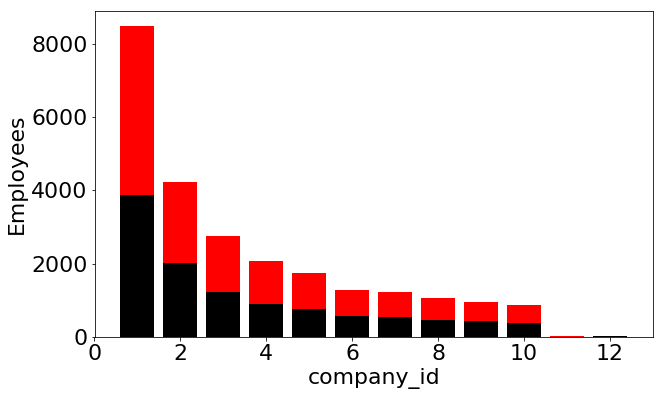

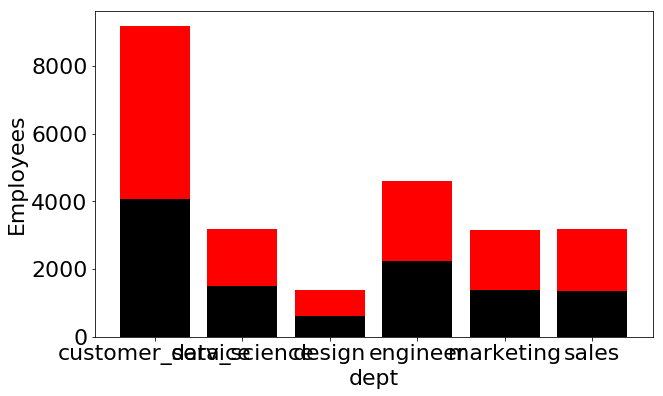

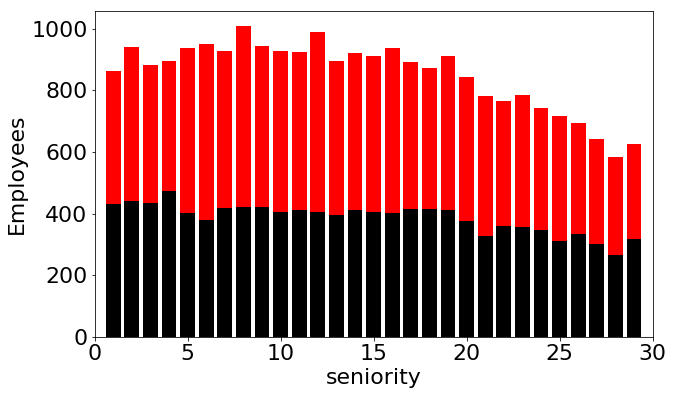

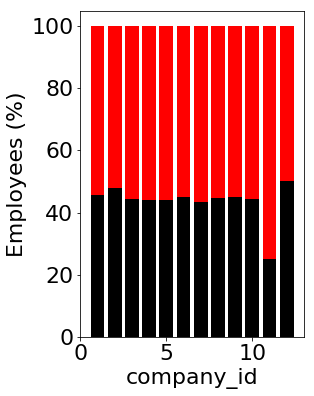

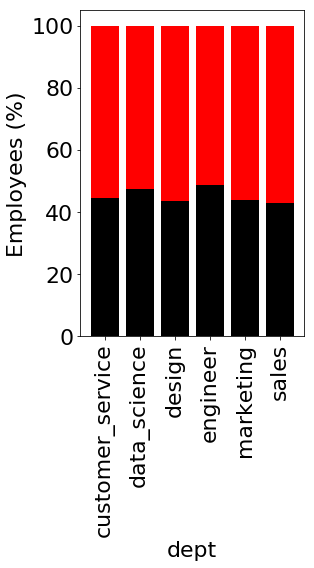

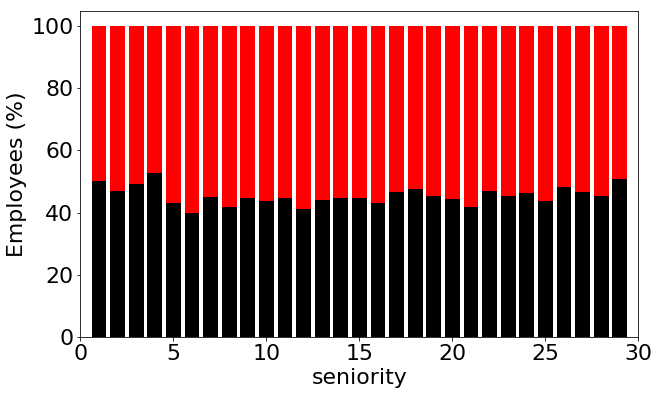

In [359]:
#Do quit rates vary by company, department or seniority level?
#Plot stacked barplots 
for col in employee_retention_original.iloc[:, 1:4]:
    plt.figure(figsize=(10,6))
    plt.rcParams.update({'font.size': 22})
    quit = employee_retention_original.groupby([col]).quit.sum()
    stayed = employee_retention_original.groupby([col]).stayed.sum()
    plt.bar(list(stayed.index), stayed, color = "black")
    plt.bar(list(quit.index), quit, bottom = stayed, color = "red")
    plt.ylabel("Employees")
    plt.xlabel(col)
    if col == "seniority":
        plt.xlim(0, 30)
    plt.show()
    
#Plots stacked barplots to 100%
for col in employee_retention_original.iloc[:, 1:4]:
    if col == "seniority":
        plt.figure(figsize=(10,6))
    else:
        plt.figure(figsize=(4,6))
    plt.rcParams.update({'font.size': 22})
    quit = employee_retention_original.groupby([col]).quit.sum()
    stayed = employee_retention_original.groupby([col]).stayed.sum()
    quit_pct = 100*(quit/(quit+stayed))
    stayed_pct = 100*(stayed/(quit+stayed))
    plt.bar(list(stayed.index), stayed_pct, color = "black")
    plt.bar(list(quit.index), quit_pct, bottom = stayed_pct, color = "red")
    plt.ylabel("Employees (%)")
    plt.xlabel(col)
    if col == "seniority":
        plt.xlim(0, 30)
    if col == "dept":
        plt.xticks(rotation = "vertical")
    plt.show()


#### Conclusion: Quit rates do not vary significantly between companies, departments, and seniority (when all data is aggregated)

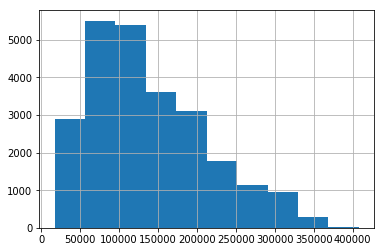

In [180]:
#employee salary histogram
employee_retention_original.salary.hist()

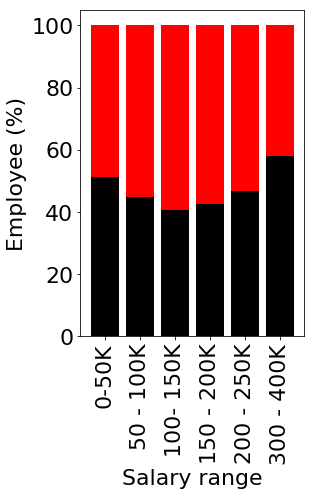

In [360]:
#Bin employee salary, 
salary_range_list = [(0, 50000), (50000, 100000), (100000, 150000), (150000, 200000), (200000, 250000), (300000, 400000)]
quit_list = []
stayed_list = []
for i in range(len(salary_range_list)):
    employee_retention_bysalary = employee_retention_original[(employee_retention_original.salary >+ salary_range_list[i][0]) & (employee_retention_original.salary < salary_range_list[i][1])]
    quit = employee_retention_bysalary.quit.sum()
    stayed = employee_retention_bysalary.stayed.sum()
    quit_pct = 100*quit/(stayed+quit)
    stayed_pct = 100*stayed/(stayed+quit)
    quit_list.append(quit_pct)
    stayed_list.append(stayed_pct)
    
salary_range_list_str = ['0-50K', '50 - 100K', '100- 150K', '150 - 200K', '200 - 250K', '300 - 400K']

plt.figure(figsize=(4,6))
plt.rcParams.update({'font.size': 22})
plt.bar(salary_range_list_str, stayed_list, color = "black")
plt.bar(salary_range_list_str, quit_list, bottom = stayed_list, color = "red")
plt.xticks(rotation = 90)
plt.xlabel("Salary range")
plt.ylabel("Employee (%)")
plt.show()


#### Conclusion: Quit rates do not vary significantly between companies, departments, seniority and salary ranges (when all data is aggregated)

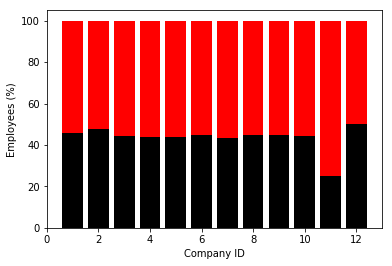

In [182]:
#Plots quit by company again
quit = employee_retention_original.groupby('company_id').quit.sum()
stayed = employee_retention_original.groupby('company_id').stayed.sum()
quit_pct = 100*(quit/(quit+stayed))
stayed_pct = 100*(stayed/(quit+stayed))
plt.bar(list(stayed.index), stayed_pct, color = "black")
plt.bar(list(quit.index), quit_pct, bottom = stayed_pct, color = "red")
plt.ylabel("Employees (%)")
plt.xlabel("Company ID")
plt.show()

### Data exploration III: 
1. For those employees who quit, how long did they stay at each company?

In [212]:
#Make length worked column for each company
employee_retention_datetimeconvert = copy.deepcopy(employee_retention_original)
employee_retention_datetimeconvert['join_date'] = pd.to_datetime(employee_retention_original.join_date)
employee_retention_datetimeconvert['quit_date'] = pd.to_datetime(employee_retention_original.quit_date)
employee_retention_datetimeconvert['daysWorked'] = (employee_retention_datetimeconvert.quit_date - employee_retention_datetimeconvert.join_date)/np.timedelta64(1, 'D')

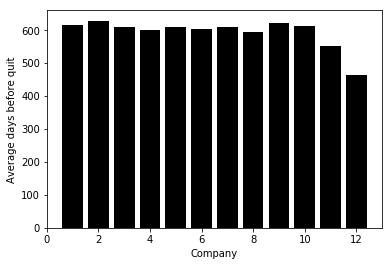

In [238]:
#Make length worked column
avg_work_length = []
for i in employee_retention_original.company_id.unique():
    quit_per_comp_df = employee_retention_datetimeconvert[(employee_retention_datetimeconvert.company_id == i) & (employee_retention_original.quit == 1)]
    avg_work_length.append(quit_per_comp_df.daysWorked.mean())
    
avg_work_length_percompany = pd.DataFrame(list(zip(employee_retention_original.company_id.unique(), avg_work_length)), columns = ['company_id', 'work_len_before_quit']).sort_values(by = "company_id")

#plot

plt.bar(avg_work_length_percompany.company_id, avg_work_length_percompany.work_len_before_quit, color = "black")
plt.xlabel("Company")
plt.ylabel("Average days before quit")
plt.show()


In [ ]:
####eliminate anyone who's stayed joined < 650 days ago

2. Quitting and joining plotted by year

In [269]:
### How many joined and quit each year
quit_by_year = pd.DataFrame(employee_retention_datetimeconvert.quit_date.dt.year.value_counts()).reset_index()
join_by_year = pd.DataFrame(employee_retention_datetimeconvert.join_date.dt.year.value_counts()).reset_index()

quit_by_year = quit_by_year.sort_values(by='index')
join_by_year = join_by_year.sort_values(by='index')

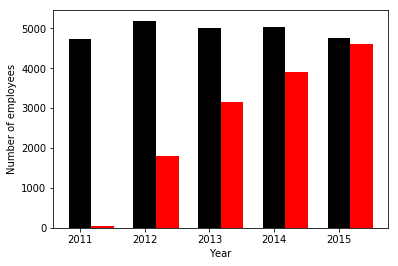

In [292]:
width = 0.35
plt.bar(join_by_year["index"], join_by_year.join_date, width, color = "black")
plt.bar(quit_by_year["index"]+width, quit_by_year.quit_date, width, color = "red")
plt.ylabel("Number of employees")
plt.xlabel("Year")
plt.show()

In [364]:
# of employees leaving every year, per company
for comp in list(employee_retention_datetimeconvert.company_id.unique()):
    quit_by_year_percomp = pd.DataFrame(employee_retention_datetimeconvert[employee_retention_datetimeconvert.company_id == comp].quit_date.dt.year.value_counts()).reset_index()
    print(comp)
    print(quit_by_year_percomp)

7
    index  quit_date
0  2015.0        230
1  2014.0        192
2  2013.0        179
3  2012.0         90
4  2011.0          1
4
    index  quit_date
0  2015.0        405
1  2014.0        306
2  2013.0        278
3  2012.0        158
4  2011.0          6
2
    index  quit_date
0  2015.0        766
1  2014.0        640
2  2013.0        508
3  2012.0        287
4  2011.0          5
9
    index  quit_date
0  2015.0        177
1  2014.0        168
2  2013.0        105
3  2012.0         79
1
    index  quit_date
0  2015.0       1564
1  2014.0       1377
2  2013.0       1064
3  2012.0        604
4  2011.0         12
6
    index  quit_date
0  2015.0        229
1  2014.0        200
2  2013.0        175
3  2012.0        105
4  2011.0          3
10
    index  quit_date
0  2015.0        179
1  2014.0        142
2  2013.0         95
3  2012.0         62
4  2011.0          2
5
    index  quit_date
0  2015.0        334
1  2014.0        278
2  2013.0        247
3  2012.0        123
4  2011.0        

### Model #1: Logistic Regression to predict whether employee quits of stays
1. One hot encode data.
2. Train model on whole data set. 
3. Train model for each library separately.

In [326]:
#One hot encode appropriate variables
all_companies_df_for_model1 = employee_retention_datetimeconvert.drop(columns = ["employee_id", "join_date", "quit_date", "stayed", "daysWorked"])
comp_id_onehot = pd.get_dummies(all_companies_df_for_model1.company_id, prefix = "company_id")
dept_onehot = pd.get_dummies(all_companies_df_for_model1.dept, prefix = "dept")
all_companies_df_for_model1_onehot = pd.concat([comp_id_onehot, dept_onehot, all_companies_df_for_model1.seniority, all_companies_df_for_model1.salary, all_companies_df_for_model1.quit], axis = 1)

In [341]:
#Logistic regression
X = all_companies_df_for_model1_onehot.drop(columns = "quit")
y = all_companies_df_for_model1_onehot.quit

logreg = LogisticRegression(solver='liblinear', penalty = "l2")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)
logreg.fit(X_train, y_train)
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))
print(precision_score(y_test, logreg.predict(X_test)))
print(recall_score(y_test, logreg.predict(X_test)))

0.5474419310763625
0.5448289819874519
0.5448289819874519
1.0


In [351]:
#Make new dataframe to build separate models for all companies (using seniority, salary and sept data)
reduced_df = employee_retention_datetimeconvert.drop(columns = ["employee_id", "join_date", "quit_date", "stayed", "daysWorked", "dept"])
separate_companies_df_for_model2 = pd.concat([reduced_df, dept_onehot], axis = 1)

In [356]:
# build separate models for all companies??
for comp in list(separate_companies_df_for_model2.company_id.unique()):
    print("Company:", comp)
    X = separate_companies_df_for_model2[separate_companies_df_for_model2.company_id == comp].drop(columns = "quit")
    y = separate_companies_df_for_model2[separate_companies_df_for_model2.company_id == comp].quit
    print("Total # of samples:", X.shape[0])
    
    logreg = LogisticRegression(solver='liblinear', penalty = "l2")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)
    logreg.fit(X_train, y_train)
    print("Metrics:")
    print(logreg.score(X_train, y_train))
    print(logreg.score(X_test, y_test))
    print(precision_score(y_test, logreg.predict(X_test)))
    print(recall_score(y_test, logreg.predict(X_test)))

Company: 7
Total # of samples: 1224
Metrics:
0.5699693564862104
0.5469387755102041
0.5469387755102041
1.0
Company: 4
Total # of samples: 2062
Metrics:
0.5585203153426319
0.5617433414043583
0.5617433414043583
1.0
Company: 2
Total # of samples: 4222
Metrics:
0.5395321291086763
0.5242603550295858
0.5204582651391162
0.7447306791569087
Company: 9
Total # of samples: 961
Metrics:
0.5364583333333334
0.6062176165803109
0.6062176165803109
1.0
Company: 1
Total # of samples: 8486
Metrics:
0.546405421331762
0.5371024734982333
0.5371024734982333
1.0
Company: 6
Total # of samples: 1291
Metrics:
0.5436046511627907
0.583011583011583
0.583011583011583
1.0
Company: 10
Total # of samples: 865
Metrics:
0.546242774566474
0.5895953757225434
0.5895953757225434
1.0
Company: 5
Total # of samples: 1755
Metrics:
0.5633903133903134
0.5470085470085471
0.5470085470085471
1.0
Company: 3
Total # of samples: 2749
Metrics:
0.5607094133697135
0.5418181818181819
0.5418181818181819
1.0
Company: 8
Total # of samples: 1047


### Model #2: Predict days employed prior to quitting
1. Predict using linear regression

In [375]:
# get only employees who quit and prep data for linear regression
employee_quitonly_df = employee_retention_datetimeconvert[employee_retention_datetimeconvert.quit == 1]

Text(0,0.5,'Number of employees')

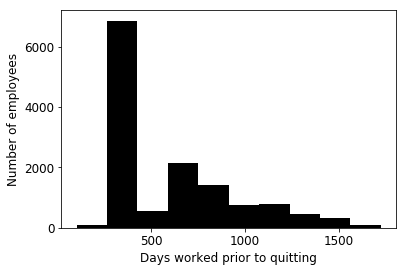

In [389]:
# Histogram of days worked prior to quitting
plot = employee_quitonly_df.daysWorked.hist(color = "black", grid = False, xlabelsize = 12, ylabelsize = 12)
plot.set_xlabel("Days worked prior to quitting", size = 12)
plot.set_ylabel("Number of employees", size = 12)

In [378]:
#drop columns that will not be used for prediction.
employee_quitonly_df_alldropped = employee_quitonly_df.drop(columns = ["employee_id", "join_date", "quit_date", "quit", "stayed"])

In [391]:
#one-hot encode company_id and department
employee_quitonly_df_alldropped

#One hot encode appropriate variables
comp_id_onehot_formodel2 = pd.get_dummies(employee_quitonly_df_alldropped.company_id, prefix = "company_id")
dept_onehot_formodel2 = pd.get_dummies(employee_quitonly_df_alldropped.dept, prefix = "dept")
all_companies_df_for_model2_onehot = pd.concat([comp_id_onehot_formodel2, dept_onehot_formodel2, employee_quitonly_df_alldropped.seniority, employee_quitonly_df_alldropped.salary, employee_quitonly_df_alldropped.daysWorked], axis = 1)

In [406]:
X = all_companies_df_for_model2_onehot.drop(columns = ["daysWorked"])
y = all_companies_df_for_model2_onehot.daysWorked
X = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

linmodel = LinearRegression()
linmodel.fit(X_train, y_train)
predictions = linmodel.predict(X_test)

print(linmodel.score(X_train, y_train))
print(linmodel.score(X_test, y_test))

0.0049154958231896195
0.0019474133230407142


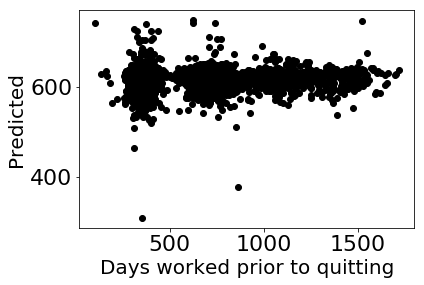

In [413]:
plt.scatter(y_test, predictions, color = "black")
plt.xlabel("Days worked prior to quitting", size = 20)
plt.ylabel("Predicted", size = 20)
plt.show()

2. Predict using random forest

In [419]:
#Try random forest for predicting days worked
X = all_companies_df_for_model2_onehot.drop(columns = ["daysWorked"])
y = all_companies_df_for_model2_onehot.daysWorked
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 40)
#Train model on TRAIN set
rfmodel.fit(X_train, y_train)
print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

Score for Test set:  -0.24708137806492125
Score for Train set:  0.7196642899742519


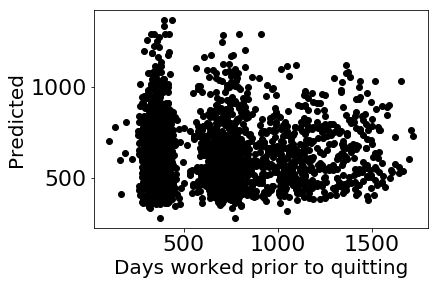

In [420]:
plt.scatter(y_test, rfmodel.predict(X_test),  color = "black")
plt.xlabel("Days worked prior to quitting", size = 20)
plt.ylabel("Predicted", size = 20)
plt.show()


**The conclusions**: 
1. Across companies, employee retention rate is similar.
2. Retention rate is also similar across departments, salary range and seniority level (when all companies aggregated).
3. An attempt to predict whether employees will quit using logistic regression was unsuccessful. 
4. At all companies, employees stay an average of 1.6 years before quitting.
5. Given the data, it is not posible to predict the number of days spent at a company prior to leaving using either linear regression or a random forest.
6. The rate of employee quitting has increased over the last 5 years at all companies.